# PyWRspice Wrapper Tutorial: Run simulation on remote SSH server

#### Prerequisite:
* You need to complete the *Tutorial.ipynb* notebook first.

Here we assume you are already famililar with running PyWRspice on a local computer.

In [1]:
# Add pyWRspice location to system path, if you haven't run setup.py
import sys
sys.path.append("../")

In [2]:
import numpy as np
import logging, importlib
from pyWRspice import script, simulation, remote

import matplotlib.pyplot as plt
%matplotlib inline
logging.basicConfig(level=logging.WARNING)

### 0. Set up a connection to an SSH server

Assume you store login info into a variable ```ssh_login = (server_name, user_name, password)```
and specify local directory as ```local_dir```, and remote directory as ```remote_dir``` to store simulation related temporary files.

Set up a handler

In [4]:
engine_remote = remote.WRWrapperSSH(ssh_login[0],ssh_login[1],ssh_login[2],
                                     local_dir=local_dir,
                                       remote_dir=remote_dir,
                                       command = "/usr/local/xictools/bin/wrspice")

## 1. Run a WRspice script one time

Let's try to run the same script from *Tutorial.ipynb*, this time on an SSH server.

In [5]:
script2 = """* Transient response of RLC circuit
.tran 50p 100n

* RLC model of a transmission line
R1 1 2 0.1
L1 2 3 1n
C1 3 0 {cap}p
R2 3 0 1e3

* Load impedance
Rload 3 0 50

* Pulse voltage source
V1 1 0 pulse(0 1 1n 1n 1n {dur}n)
*
.control
run
set filetype=binary
write {output_file} v(2) v(3)
.endc
"""


We then specify the values of ```cap``` and ```dur``` when execute the script with the ```run``` function, the same way we would do when running on local machine.

In [6]:
dat2 = engine_remote.run(script2,cap=30, dur=40)

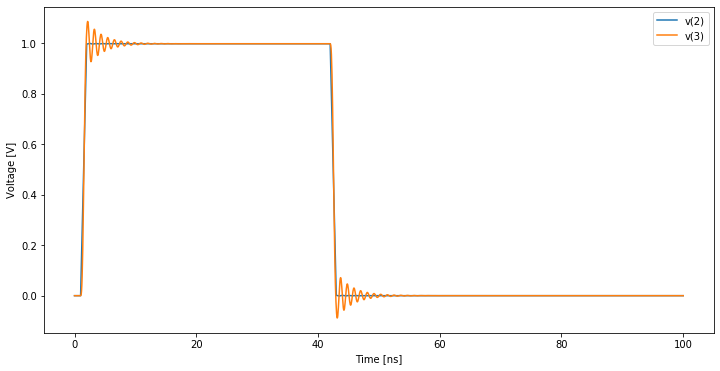

In [7]:
# Extract the data
dat2 = dat2.to_array()
ts = dat2[0]
v2 = dat2[1]
v3 = dat2[2]

# Plot the data
fig = plt.figure(figsize=(12,6))
plt.plot(ts*1e9, v2, label="v(2)")
plt.plot(ts*1e9, v3, label="v(3)")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.show()

## 2. Run WRspice script with multiple parametric values in parallel

We can pass a list of values to one or more parameters and run them all in parallel, using multiprocessing, with the ```run_parallel()``` method, almost the same way as running on a local machine, except that we now have a few more options on how to handle the files.

Comparing to its local version, the remote function ```run_parallel``` has 2 new options:
* ```save_file```: The function create a series of files (to be explained later) on the local and remote machines, such as circuit files and output files (after execution). To remove these files, set ```save_file=True``` (default).
* ```read_raw```: By default (True), the function will read the output raw files into memory. If the output data can be too large, consider set ```read_raw=False```, then the returned value is the list of output filenames (to be manually imported later).

One can control how the function returns by the parameter ```reshape```: If True, return (params,values) whose shapes are the same (same as the local version). If False, return a pandas DataFrame object containing the params and results in the column ```result```.

In [9]:
# Read the docs
engine_remote.run_parallel?

Signature:
engine_remote.run_parallel(
    *script,
    processes=64,
    save_file=True,
    reshape=True,
    read_raw=True,
    **params,
)
Docstring:
Use multiprocessing to run in parallel on remote

script: WRspice script to be simulated.
processes: number of parallel processes
if save_file==False: remove all relevant simulation files after execution (only if read_raw==True)
if reshape==False: return output data as a pandas DataFrame
if read_raw==True: import raw file into memory, otherise provide the list of output raw filenames
File:      ~/Documents/GitHub/pyWRspice/pyWRspice/remote.py
Type:      method


#### Simple case: The same way as local version.

In [8]:
params = {}
params["cap"] = [20,50,100]
params["dur"] = [40,60]

params3, dat3 = engine_remote.run_parallel(script2,save_file=False,**params)

Because ```reshape=True``` by default, the returned values are the same as in the local case.

In [10]:
# Examine the returned parameter values
for k,v in params3.items():
    print("%s = %s" %(k,v))
    print("")

cap = [[ 20  20]
 [ 50  50]
 [100 100]]

dur = [[40 60]
 [40 60]
 [40 60]]



In [11]:
# Get the shape of the returned data
dat3.shape

(3, 2)

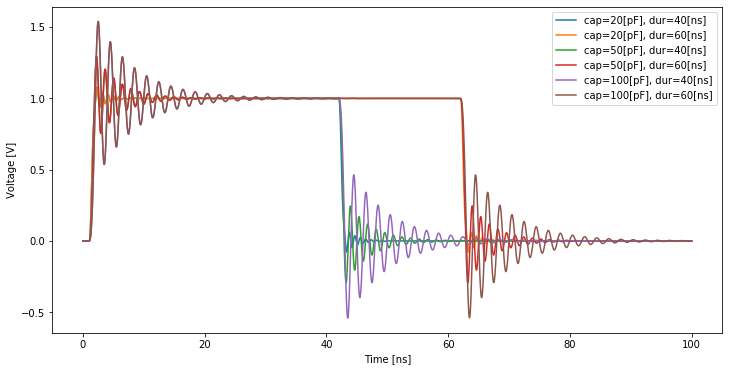

In [12]:
# Plot the data
fig = plt.figure(figsize=(12,6))
shape = dat3.shape
for i in range(shape[0]):
    for j in range(shape[1]):
        dat = dat3[i,j].to_array()
        ts = dat[0]
        v3 = dat[2]
        plt.plot(ts*1e9, v3, label="cap=%s[pF], dur=%s[ns]" %(params3["cap"][i,j],params3["dur"][i,j]))
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.show()

#### A more controlled case: turn off ```reshape``` and ```read_raw```

In [13]:
params = {}
params["cap"] = [20,50,100]
params["dur"] = [40,60]

dat4 = engine_remote.run_parallel(script2,save_file=False,reshape=False,read_raw=False,**params)

Because in this case ```reshape=False```, the returned value is a pandas DataFrame with all the simulation parameters and output.

In [14]:
dat4

,cap,dur,circuit_file,output_file,result
0,20,40,/home/mnguyen/Simulation/tmp/tmp_circuit_0.cir,/home/mnguyen/Simulation/tmp/tmp_output_0.raw,/Users/mnguyen/Documents/GitHub/tmp/tmp_output...
1,20,60,/home/mnguyen/Simulation/tmp/tmp_circuit_1.cir,/home/mnguyen/Simulation/tmp/tmp_output_1.raw,/Users/mnguyen/Documents/GitHub/tmp/tmp_output...
2,50,40,/home/mnguyen/Simulation/tmp/tmp_circuit_2.cir,/home/mnguyen/Simulation/tmp/tmp_output_2.raw,/Users/mnguyen/Documents/GitHub/tmp/tmp_output...
3,50,60,/home/mnguyen/Simulation/tmp/tmp_circuit_3.cir,/home/mnguyen/Simulation/tmp/tmp_output_3.raw,/Users/mnguyen/Documents/GitHub/tmp/tmp_output...
4,100,40,/home/mnguyen/Simulation/tmp/tmp_circuit_4.cir,/home/mnguyen/Simulation/tmp/tmp_output_4.raw,/Users/mnguyen/Documents/GitHub/tmp/tmp_output...
5,100,60,/home/mnguyen/Simulation/tmp/tmp_circuit_5.cir,/home/mnguyen/Simulation/tmp/tmp_output_5.raw,/Users/mnguyen/Documents/GitHub/tmp/tmp_output...


Because ```read_raw=False```, the returned output is a list of output raw filenames.

In [16]:
for fname in dat4["result"]:
    print(fname)

/Users/mnguyen/Documents/GitHub/tmp/tmp_output_0.raw
/Users/mnguyen/Documents/GitHub/tmp/tmp_output_1.raw
/Users/mnguyen/Documents/GitHub/tmp/tmp_output_2.raw
/Users/mnguyen/Documents/GitHub/tmp/tmp_output_3.raw
/Users/mnguyen/Documents/GitHub/tmp/tmp_output_4.raw
/Users/mnguyen/Documents/GitHub/tmp/tmp_output_5.raw


So we need to do some extra steps to read the output data and reshape them. We can do so manually, or run the function ```reshape_result```.

In [17]:
params4, dat4r = engine_remote.reshape_results(dat4,params)

In [18]:
# Examine the returned parameter values
for k,v in params4.items():
    print("%s = %s" %(k,v))
    print("")

cap = [[ 20  20]
 [ 50  50]
 [100 100]]

dur = [[40 60]
 [40 60]
 [40 60]]



In [20]:
# Get the shape of the returned data
# Note that it is an array of output raw filenames
dat4r.shape

(3, 2)

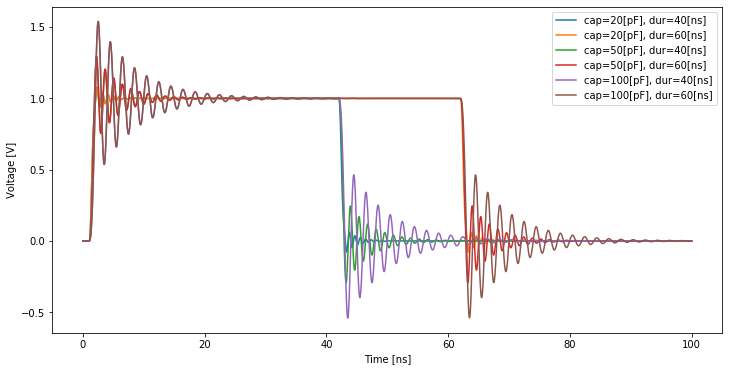

In [22]:
# Plot the data
fig = plt.figure(figsize=(12,6))
shape = dat4r.shape
for i in range(shape[0]):
    for j in range(shape[1]):
        dat = simulation.RawFile(dat4r[i,j]).to_array() # Need to import the raw file using RawFile class
        ts = dat[0]
        v3 = dat[2]
        plt.plot(ts*1e9, v3, label="cap=%s[pF], dur=%s[ns]" %(params3["cap"][i,j],params3["dur"][i,j]))
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.show()

## 3. Run long simulation on server

The ways we have run the simulation so far are appropriate for rather light-weight simulation which is expected to be completed in an hour or so on the server. When running heavy simulation on the server, we want to have the simulation running while we can disconnect the SSH connection, then we can be back later to collect the output.

The way to do so is to break up the function ```run_parallel``` into multiple steps: prepare the files needed for the simulation on the server, then manually execute the simulation, then collect the result.

#### Prepare the files

The function ```prepare_parallel``` creates local and remote copies of the circuit files. It returns a configuration file containing information for execution.

If there are additional files needed for the simulation (e.g. input files), they have to be copied to the server by the function ```put```.

In [25]:
fconfig = engine_remote.prepare_parallel(script2,**params)
print(fconfig)

simconfig_20200107_173940.csv


In [26]:
# Let's read the first line of fconfig. We can get the local path by function local_fname
with open(engine_remote.local_fname(fconfig),'r') as f:
    print(f.readline())

# To run manually: python run_parallel.py simconfig_20200107_173940.csv --processes=<num>



#### Execute
As shown above, the command to execute the simulation is ```python run_parallel.py simconfig_20200107_173940.csv --processes=<num>```. How to do it (safely):
1. Manually SSH log in to the server
2. Change directory ```cd``` to the working directory ```engine_remote.remote_dir```
3. Create a separate session by running the command ```screen``` (or ```screen -S <name>``` to specify the screen name)
4. Run the above command: ```python run_parallel.py simconfig_20200107_173940.csv``` with optional ```--processes=<num>``` (```num``` is the number of processes in parallel, default is 64)
5. Then hit ```Ctrl + a``` and ```d``` to detach from the screen session
6. Now you can disconnect from the SSH server. The job will continue in the background.

#### Collect results

Two ways to check if the job is done:
* Manually log in to the server, change to ```remote_dir``` and check if the file ```finish_<fconfig>.txt``` exists (when the simulation is completed, it will create that file).
* Run the function ```get_results``` to automatically check and collect the output files.

In [27]:
dat5 = engine_remote.get_results(fconfig,timeout=100,read_raw=False)

Because we set ```read_raw=False```, the returned ```dat5``` is the same as ```dat4``` above. We need to run extra steps to reshape and read the output.

In [29]:
params5, dat5r = engine_remote.reshape_results(dat5,params)
# The results should be the same as params4 and dat4r above

In [30]:
# Finally, after analyzing the results, we need to remove the temp files (circuit and output files, etc)
engine_remote.remove_fconfig(fconfig, dest="both") # Set dest="local" or dest="remote" if necessary